## Load the data sets

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
df=pd.read_csv(r"C:\Users\praba\Desktop\Spam Detection\data\spam.csv",encoding='latin-1')

In [3]:
df.head()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


(5572, 5)

## Clean and Processed Data

In [5]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True,axis=1, errors='ignore')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:

df.rename(columns={'v1': 'label', 'v2': 'text'},inplace=True)

In [7]:
df['label_enc']=df['label'].map({'ham': 0, 'spam': 1})

In [8]:
print(df.isnull().sum())

label        0
text         0
label_enc    0
dtype: int64


In [9]:
df=df.drop_duplicates()

# Text Preprocessing

In [10]:
! pip install contractions

In [11]:
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import contractions

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\praba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
def preprocess_text(text):

    text = contractions.fix(text)

    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text, flags=re.MULTILINE)
    text = re.sub(r'\S*@\S*\s?', '<EMAIL>', text)
    text = re.sub(r'\d+', '<NUM>', text)
    
    text = re.sub(r'[^a-zA-Z\s!?$]', '', text)
    
    words = text.split()

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

In [13]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [14]:
df['cleaned_text'].head()

0    go jurong point crazy available bugis n great ...
1                                ok lar joking wif oni
2    free entry NUM wkly comp win fa cup final tkts...
3                      dun say early hor c already say
4                  nah think go usf life around though
Name: cleaned_text, dtype: object

## Feature Extraction

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_ngram =TfidfVectorizer(max_features=5000, lowercase=True, stop_words='english', ngram_range=(1, 2))
X = df['cleaned_text']
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tfidf = tfidf_ngram.fit_transform(X_train)
X_test_tfidf = tfidf_ngram.transform(X_test)



## Train ML Model

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [17]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naives Bayes": MultinomialNB()
}


def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores


In [18]:
model_scores = fit_and_score(models,
                            X_train_tfidf,
                            X_test_tfidf, 
                            y_train, 
                            y_test)
print(model_scores)


{'Logistic Regression': 0.9593810444874274, 'KNN': 0.9013539651837524, 'Random Forest': 0.9748549323017408, 'Naives Bayes': 0.9680851063829787}


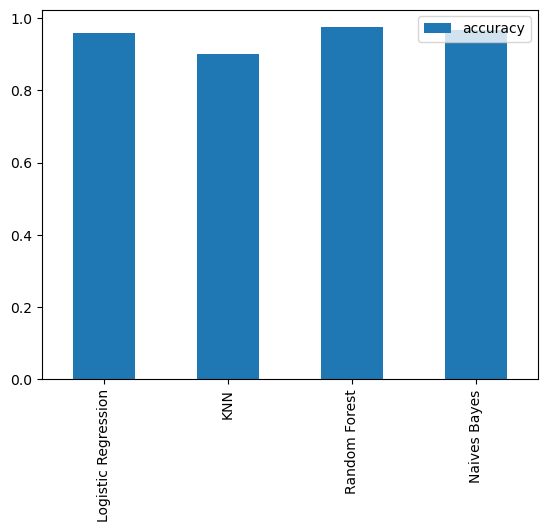

In [19]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

## Evaluate Model Performance

In [20]:
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

--- Logistic Regression ---
Confusion Matrix:
 [[884   5]
 [ 37 108]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       889
           1       0.96      0.74      0.84       145

    accuracy                           0.96      1034
   macro avg       0.96      0.87      0.91      1034
weighted avg       0.96      0.96      0.96      1034

--- KNN ---
Confusion Matrix:
 [[889   0]
 [102  43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       889
           1       1.00      0.30      0.46       145

    accuracy                           0.90      1034
   macro avg       0.95      0.65      0.70      1034
weighted avg       0.91      0.90      0.88      1034

--- Random Forest ---
Confusion Matrix:
 [[889   0]
 [ 26 119]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97     

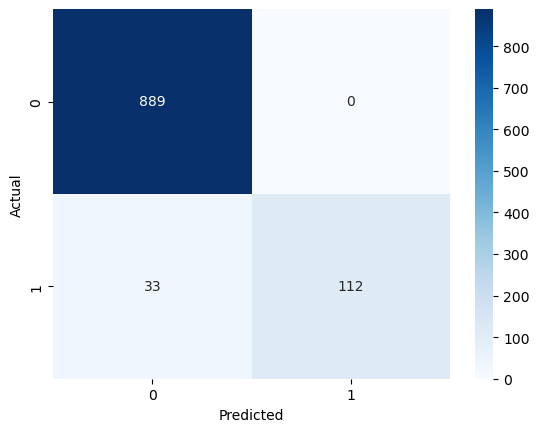

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
nb_model=models["Naives Bayes"]

## Hypertuning of the model


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

param_grid={
    'alpha':[0.001,0.01,0.1,0.5,1,5,10]
}

In [24]:
grid_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_nb.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


In [25]:
print("Best Parameters:",grid_nb.best_params_)
print("Best Cross-Validation:",grid_nb.best_score_)

Best Parameters: {'alpha': 0.1}
Best Cross-Validation: 0.9859733978234584


In [26]:
best_nb_model=grid_nb.best_estimator_

In [27]:
y_pred=best_nb_model.predict(X_test_tfidf)

In [28]:
print("\n--- Evaluation on Test Data ---")
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("\nClassification Report:\n",classification_report(y_test,y_pred))


--- Evaluation on Test Data ---
Confusion Matrix:
 [[888   1]
 [ 16 129]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.99      0.89      0.94       145

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [29]:
def predict_spam(message,model=best_nb_model,vectorizer=tfidf_ngram):

    cleaned_message=preprocess_text(message)
    message_tfidf=vectorizer.transform([cleaned_message])

    prediction=model.predict(message_tfidf)[0]
    probability=model.predict_proba(message_tfidf)[0]

    result="Spam" if prediction == 1 else "Ham"
    confidence=max(probability)

    return f"Prediction: {result} (Confidence: {confidence:.4f})"

test_message = "Congratulations! You've won $1000! Click here to claim now!"
print(predict_spam(test_message))


Prediction: Spam (Confidence: 0.9788)


## Save Trained Model

In [ ]:
import joblib

joblib.dump(best_nb_model, r"C:\Users\praba\Desktop\Spam Detection\model\naive_bayes_spam_model.pkl")
joblib.dump(tfidf_ngram, r"C:\Users\praba\Desktop\Spam Detection\model\tfidf_vectorizer.pkl")


['C:\\Users\\praba\\Desktop\\Spam-Detection\\model\\tfidf_vectorizer.pkl']